# FEATURE ENGINEERING

## Libraries & Data Cleaning

In [1]:
%config Completer.use_jedi = False

# Je narrivait pas a installer la librairy textBlob depuis la UI Anaconda
# Les 3 lignes ci-dessous sont a faire tourner une seule fois:

# import sys
# !{sys.executable} -m pip install textblob
# !{sys.executable} -m pip install textblob_fr


import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fileName = 'df_complet.csv'
pathName = './Data'


# df=pd.read_excel(f'{pathName}\{fileName}')
df=pd.read_csv(f'{pathName}/{fileName}')

In [2]:

# Suppression des valeurs NaN dans Titres et commentaires
df = df.dropna(subset=['Commentaire','Titres'],how='all')
df['Commentaire'] = df['Commentaire'].fillna('')
df['Titres'] = df['Titres'].fillna('')

#Suppression des lignes avec Titres et commentaire egale a '' (string vide):
df = df.drop(df[(df.Commentaire == '') & (df.Titres == '')].index)

# Suppresion des Lignes redondantes:
df = df.drop_duplicates()

#df = df.drop(df.loc[df.Titres.apply(lambda x: not(isinstance(x, str)))].index)
print(df.columns)
df.reset_index()

#Convertir toutes les valeurs de Commentaire et Titre en Object:string:
df['Commentaire'] = df['Commentaire'].astype(str)
df['Titres'] = df['Titres'].astype(str)

# Remplacement des characteres non ASCII:
items = {"ä": "a", "ç": "c", "è": "e", "º": "", "Ã": "A", "Í": "I", "í": "i", "Ü": "U", "â": "a", "ò": "o", "¿": "",
             "ó": "o", "á": "a", "à": "a", "õ": "o", "¡": "", "Ó": "O", "ù": "u", "Ú": "U", "´": "", "Ñ": "N", "Ò": "O",
             "ï": "i", "Ï": "I", "Ç": "C", "À": "A", "É": "E", "ë": "e", "Á": "A", "ã": "a", "Ö": "O", "ú": "u",
             "ñ": "n", "é": "e", "ê": "e", "·": "-", "ª": "a", "°": "", "ü": "u", "ô": "o","+":"plus","-":"moins","_":" "}

df['Commentaire'] = df['Commentaire'].str.replace(r'[^\x00-\x7F]', lambda x: items.get(x.group(0)) or '_', regex=True)
df['Titres'] = df['Titres'].str.replace(r'[^\x00-\x7F]', lambda x: items.get(x.group(0)) or '_', regex=True)

# Conversion des date en objet datetime:
df.Date_experience =  pd.to_datetime(df.Date_experience)
df.Date_publication =  pd.to_datetime(df.Date_publication)

print(f'Commentaire NAN: {df.Commentaire.isna().sum()}')
print(f'Commentaire Null: {df.Commentaire.isnull().sum()}')
print(f'Titres NAN: {df.Titres.isna().sum()}')
print(f'Nombre_avis_publie NAN: {df.Nombre_avis_publie.isna().sum()}')
print(f'Verifications NAN: {df.Verifications.isna().sum()}')
print(f'Date_experience NAN: {df.Date_experience.isna().sum()}')
print(f'Date_publication NAN: {df.Date_publication.isna().sum()}')

print(f'\nNombres de lignes: {len(df)}')

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Client', 'Nombre_avis_publie', 'Note',
       'Titres', 'Commentaire', 'Date_experience', 'Date_publication',
       'Reponse', 'Date_reponse', 'Pays', 'Verifications', 'Entreprise'],
      dtype='object')
Commentaire NAN: 0
Commentaire Null: 0
Titres NAN: 0
Nombre_avis_publie NAN: 0
Verifications NAN: 0
Date_experience NAN: 0
Date_publication NAN: 0

Nombres de lignes: 285983


## Commentaires et Titre 

### Nombres de mots et characteres:

In [3]:
df['longCommentaire']  = df.Commentaire.apply(lambda x: len(x))
df['longTitres']  = df.Titres.apply(lambda x: len(x))

In [4]:
df['nb_Mots_Commentaire']  = df.Commentaire.apply(lambda x: len(x.split(' ')))
df['nb_Mots_Titres']  = df.Titres.apply(lambda x: len(x.split(' ')))

### Ponctuations, nombres, characteres speciaux:

In [5]:
def Count_special(str):
    upper, lower, number, ponctuation, special = 0, 0, 0, 0, 0
    for i in range(len(str)):
        if str[i].isupper():
            upper += 1
        elif str[i].islower():
            lower += 1
        elif str[i].isdigit():
            number += 1
        elif str[i] in ['!','?']:
            ponctuation += 1
            
        elif str[i] in '@#$%&+=-<>~/\"*(){}[]':
            special += 1
#     print('Upper case letters:', upper)
#     print('Lower case letters:', lower)
#     print('Number:', number)
#     print('Ponctuation:', ponctuation)
#     print('Special characters:', special)
    
    return upper,lower,number,ponctuation,special


In [6]:
df['nb_majuscules_Commentaire'], _, df['nb_chiffres_Commentaire'], df['nb_ponctuation_Commentaire'],df['nb_special_Commentaire'] = zip(*df.Commentaire.apply(lambda x: Count_special(x)))

In [7]:
df['nb_majuscules_Titre'], _, df['nb_chiffres_Titre'], df['nb_ponctuation_Titre'],df['nb_special_Titre'] = zip(*df.Titres.apply(lambda x: Count_special(x)))

### Mots Clefs: (A terminer)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None, ngrame=1,stopWord=True):
    """
    Compte le nombre de recurrences des ngrames presents dans le corpus et retourne le top n ngrames et leur decomptes.

    :param corpus: Serie, incluant 1 seul colonne de string
    :param n: int, Nombre de Ngrame a collecter apres triage
    :param ngrame: int, ordre du Ngrame vise. 1 mot = 1grame, couple mots se suivant = 2grame, etc
    :param stopWord: Boolean, filtre les stopWord present dans les string. La list de stop word est definie dans la
    fonction. StopWord example = le,la,les,de,je,etc
    :return: List of tuple, [(mot,nombre recense)]
    """

    items = {"ä": "a", "ç": "c", "è": "e", "º": "", "Ã": "A", "Í": "I", "í": "i", "Ü": "U", "â": "a", "ò": "o", "¿": "",
             "ó": "o", "á": "a", "à": "a", "õ": "o", "¡": "", "Ó": "O", "ù": "u", "Ú": "U", "´": "", "Ñ": "N", "Ò": "O",
             "ï": "i", "Ï": "I", "Ç": "C", "À": "A", "É": "E", "ë": "e", "Á": "A", "ã": "a", "Ö": "O", "ú": "u",
             "ñ": "n", "é": "e", "ê": "e", "·": "-", "ª": "a", "°": "", "ü": "u", "ô": "o","+":"plus","-":"moins","_":" "}

    stopWordFrench = ['alors','au','ai','aucuns','aussi','autre','avant','avec','avoir','bon','car','ce','cela',
                      'ces','ceux','chaque','ci','comme','comment','dans','de','des','du','dedans','dehors','depuis',
                      'devrait','doit','donc','dos','debut','elle','elles','en','encore','essai','est','et','eu',
                      'fait','faites','fois','font','hors','ici','il','ils','je','juste','la','le','les','leur','ma',
                      'maintenant','mais','mes','mien','moins','mon','mot','meme','ni','nommes','notre','nous','ou',
                      'par','parce','peut','plupart','pour','pourquoi','quand','que','quel','quelle','quelles',
                      'quels','qui','sa','sans','ses','seulement','si','sien','son','sont','sous','soyez','sujet',
                      'sur','ta','un','une','tandis','tellement','tels','tes','ton','tous','tout','tres','tu',
                      'voient','vont','votre','vous','vu','ca','etaient','etat','etions','ete','etre','me','chez',
                      'on','ont',"de_","et_","la_","le_","j_ai","j_"]

    stopWord = stopWordFrench if stopWord else None

    corpus = corpus.str.replace(r'[^\x00-\x7F]', lambda x: items.get(x.group(0)) or '_', regex=True)

    vec = CountVectorizer(ngram_range=(ngrame, ngrame), stop_words=stopWord).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

In [9]:
def getSelectedWord(columnTargeted='',ngrame=1,ngrame_nb=3):
    common_words=[]
    for note in range(1,6):
        common_words += get_top_ngram(df.loc[df.Note==note][columnTargeted], n=ngrame_nb,ngrame=ngrame,stopWord=True)


    wordOnlyList=[x[0] for x in common_words]

    #Conserve les strings unique
    selected_words= []
    [selected_words.append(x) for x in wordOnlyList if x not in selected_words]

    return selected_words


In [10]:
def getVecAndBagWords(columnTargeted='',ngrame=1):

    corpus = df[columnTargeted]

    items = {"ä": "a", "ç": "c", "è": "e", "º": "", "Ã": "A", "Í": "I", "í": "i", "Ü": "U", "â": "a", "ò": "o", "¿": "",
             "ó": "o", "á": "a", "à": "a", "õ": "o", "¡": "", "Ó": "O", "ù": "u", "Ú": "U", "´": "", "Ñ": "N", "Ò": "O",
             "ï": "i", "Ï": "I", "Ç": "C", "À": "A", "É": "E", "ë": "e", "Á": "A", "ã": "a", "Ö": "O", "ú": "u",
             "ñ": "n", "é": "e", "ê": "e", "·": "-", "ª": "a", "°": "", "ü": "u", "ô": "o","+":"plus","-":"moins","_":" "}

    stopWordFrench = ['alors','au','ai','aucuns','aussi','autre','avant','avec','avoir','bon','car','ce','cela',
                      'ces','ceux','chaque','ci','comme','comment','dans','de','des','du','dedans','dehors','depuis',
                      'devrait','doit','donc','dos','debut','elle','elles','en','encore','essai','est','et','eu',
                      'fait','faites','fois','font','hors','ici','il','ils','je','juste','la','le','les','leur','ma',
                      'maintenant','mais','mes','mien','moins','mon','mot','meme','ni','nommes','notre','nous','ou',
                      'par','parce','peut','plupart','pour','pourquoi','quand','que','quel','quelle','quelles',
                      'quels','qui','sa','sans','ses','seulement','si','sien','son','sont','sous','soyez','sujet',
                      'sur','ta','un','une','tandis','tellement','tels','tes','ton','tous','tout','tres','tu',
                      'voient','vont','votre','vous','vu','ca','etaient','etat','etions','ete','etre','me','chez',
                      'on','ont',"de_","et_","la_","le_","j_ai","j_"]


    corpus = corpus.str.replace(r'[^\x00-\x7F]', lambda x: items.get(x.group(0)) or '_', regex=True)

    vec = CountVectorizer(ngram_range=(ngrame, ngrame), stop_words=stopWordFrench).fit(corpus)

    bag_of_words = vec.transform(corpus)

    return vec, bag_of_words


In [11]:
def addNewColumnNgrame(df2=df.copy(),columnTargeted='',ngrame=1):
    
    selected_words = getSelectedWord(columnTargeted=columnTargeted,ngrame=ngrame)
    
    vec, bag_of_words = getVecAndBagWords(columnTargeted=columnTargeted,ngrame=ngrame)
    
    print(f'Ngrame Selectionne: {selected_words}')

    newColname=[]
    for word in selected_words:
        newColname.append(columnTargeted +'_' +str(ngrame)+'grame_'+word.replace(' ','_'))
        df2[columnTargeted +'_' +str(ngrame)+'grame_'+word.replace(' ','_')] = [bag_of_words[i,vec.vocabulary_[word]] if word in vec.vocabulary_.keys() else 0 for i in range(len(df))]

    print(f'Nouvelles colonnes: {newColname}')
    
    return df2


In [12]:
ngrame=1
columnTargeted = 'Commentaire'

df = addNewColumnNgrame(df2=df.copy(),columnTargeted=columnTargeted,ngrame=ngrame)


Ngrame Selectionne: ['pas', 'pneus', 'commande', 'livraison', 'rapide', 'prix']
Nouvelles colonnes: ['Commentaire_1grame_pas', 'Commentaire_1grame_pneus', 'Commentaire_1grame_commande', 'Commentaire_1grame_livraison', 'Commentaire_1grame_rapide', 'Commentaire_1grame_prix']


In [13]:
ngrame=2
columnTargeted = 'Commentaire'

df = addNewColumnNgrame(df2=df.copy(),columnTargeted=columnTargeted,ngrame=ngrame)


Ngrame Selectionne: ['toujours pas', 'commande pneus', 'pas recu', 'ne pas', 'delai livraison', 'livraison rapide', 'qualite prix', 'rapport qualite']
Nouvelles colonnes: ['Commentaire_2grame_toujours_pas', 'Commentaire_2grame_commande_pneus', 'Commentaire_2grame_pas_recu', 'Commentaire_2grame_ne_pas', 'Commentaire_2grame_delai_livraison', 'Commentaire_2grame_livraison_rapide', 'Commentaire_2grame_qualite_prix', 'Commentaire_2grame_rapport_qualite']


In [14]:
ngrame=3
columnTargeted = 'Commentaire'

df = addNewColumnNgrame(df2=df.copy(),columnTargeted=columnTargeted,ngrame=ngrame)

Ngrame Selectionne: ['toujours pas recu', 'service apres vente', 'pas recu pneus', 'ne suis pas', 'rapport qualite prix', 'livraison trop long', 'livraison peu longue', 'livraison peu long', 'prix livraison rapide', 'livraison rapide conforme']
Nouvelles colonnes: ['Commentaire_3grame_toujours_pas_recu', 'Commentaire_3grame_service_apres_vente', 'Commentaire_3grame_pas_recu_pneus', 'Commentaire_3grame_ne_suis_pas', 'Commentaire_3grame_rapport_qualite_prix', 'Commentaire_3grame_livraison_trop_long', 'Commentaire_3grame_livraison_peu_longue', 'Commentaire_3grame_livraison_peu_long', 'Commentaire_3grame_prix_livraison_rapide', 'Commentaire_3grame_livraison_rapide_conforme']


In [15]:
ngrame=1
columnTargeted = 'Titres'

df = addNewColumnNgrame(df2=df.copy(),columnTargeted=columnTargeted,ngrame=ngrame)

Ngrame Selectionne: ['pas', 'commande', 'pneus', 'livraison', 'rapide', 'bien', 'prix']
Nouvelles colonnes: ['Titres_1grame_pas', 'Titres_1grame_commande', 'Titres_1grame_pneus', 'Titres_1grame_livraison', 'Titres_1grame_rapide', 'Titres_1grame_bien', 'Titres_1grame_prix']


In [16]:
ngrame=2
columnTargeted = 'Titres'

df = addNewColumnNgrame(df2=df.copy(),columnTargeted=columnTargeted,ngrame=ngrame)

Ngrame Selectionne: ['toujours pas', 'pas recu', 'commande pneus', 'trop long', 'livraison trop', 'delai livraison', 'livraison rapide', 'qualite prix', 'rapport qualite']
Nouvelles colonnes: ['Titres_2grame_toujours_pas', 'Titres_2grame_pas_recu', 'Titres_2grame_commande_pneus', 'Titres_2grame_trop_long', 'Titres_2grame_livraison_trop', 'Titres_2grame_delai_livraison', 'Titres_2grame_livraison_rapide', 'Titres_2grame_qualite_prix', 'Titres_2grame_rapport_qualite']


In [17]:
ngrame=3
columnTargeted = 'Titres'

df = addNewColumnNgrame(df2=df.copy(),columnTargeted=columnTargeted,ngrame=ngrame)

Ngrame Selectionne: ['toujours pas recu', 'pas recu commande', 'pas recu pneus', 'livraison trop long', 'livraison trop longue', 'delai livraison trop', 'rapport qualite prix', 'livraison rapide conforme', 'livraison peu longue', 'livraison rapide prix']
Nouvelles colonnes: ['Titres_3grame_toujours_pas_recu', 'Titres_3grame_pas_recu_commande', 'Titres_3grame_pas_recu_pneus', 'Titres_3grame_livraison_trop_long', 'Titres_3grame_livraison_trop_longue', 'Titres_3grame_delai_livraison_trop', 'Titres_3grame_rapport_qualite_prix', 'Titres_3grame_livraison_rapide_conforme', 'Titres_3grame_livraison_peu_longue', 'Titres_3grame_livraison_rapide_prix']


In [18]:
print(df.columns)
print(df.head(20))

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Client', 'Nombre_avis_publie', 'Note',
       'Titres', 'Commentaire', 'Date_experience', 'Date_publication',
       'Reponse', 'Date_reponse', 'Pays', 'Verifications', 'Entreprise',
       'longCommentaire', 'longTitres', 'nb_Mots_Commentaire',
       'nb_Mots_Titres', 'nb_majuscules_Commentaire',
       'nb_chiffres_Commentaire', 'nb_ponctuation_Commentaire',
       'nb_special_Commentaire', 'nb_majuscules_Titre', 'nb_chiffres_Titre',
       'nb_ponctuation_Titre', 'nb_special_Titre', 'Commentaire_1grame_pas',
       'Commentaire_1grame_pneus', 'Commentaire_1grame_commande',
       'Commentaire_1grame_livraison', 'Commentaire_1grame_rapide',
       'Commentaire_1grame_prix', 'Commentaire_2grame_toujours_pas',
       'Commentaire_2grame_commande_pneus', 'Commentaire_2grame_pas_recu',
       'Commentaire_2grame_ne_pas', 'Commentaire_2grame_delai_livraison',
       'Commentaire_2grame_livraison_rapide',
       'Commentaire_2grame_qualite_prix', 'Com

### Sentiment Polarity (TextBlob)

In [19]:
# Code:

from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

#print(df.loc[df.Commentaire.apply(lambda x: not(isinstance(x, str)))].head())
# df = df.drop(df.loc[df.Commentaire.apply(lambda x: not(isinstance(x, str)))].index)
# df.reset_index()
#df.info()

# Definit objet blobber et configure les modeles francais
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

# Fonction nettoyant le text
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')
    return ReviewText


df['Titres'] = preprocess(df['Titres'])
df['Commentaire'] = preprocess(df['Commentaire'])
df['polarity_Commentaire'] = df['Commentaire'].map(lambda text: tb(text).sentiment[0])
df['polarity_Titres'] = df['Titres'].map(lambda text: tb(text).sentiment[0])

C:\Users\joan\AppData\Local\Temp\ipykernel_16232\899469321.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  ReviewText = ReviewText.str.replace("(<br/>)", "")
C:\Users\joan\AppData\Local\Temp\ipykernel_16232\899469321.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
C:\Users\joan\AppData\Local\Temp\ipykernel_16232\899469321.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  ReviewText = ReviewText.str.replace('(&amp)', '')
C:\Users\joan\AppData\Local\Temp\ipykernel_16232\899469321.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  ReviewText = ReviewText.str.replace('(&gt)', '')
C:\Users\joan\AppData\Local\Temp\ipykernel_16232\899469321.py:20: FutureWarning: The default value of regex will change from True to False in

### Date Experience transforme en saison

In [20]:
df['Saison_experience'] = df.Date_experience.apply(lambda x: x.month%12 // 3 + 1)

## Conclusion

### Details:

In [21]:
print(df.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Client', 'Nombre_avis_publie', 'Note',
       'Titres', 'Commentaire', 'Date_experience', 'Date_publication',
       'Reponse', 'Date_reponse', 'Pays', 'Verifications', 'Entreprise',
       'longCommentaire', 'longTitres', 'nb_Mots_Commentaire',
       'nb_Mots_Titres', 'nb_majuscules_Commentaire',
       'nb_chiffres_Commentaire', 'nb_ponctuation_Commentaire',
       'nb_special_Commentaire', 'nb_majuscules_Titre', 'nb_chiffres_Titre',
       'nb_ponctuation_Titre', 'nb_special_Titre', 'Commentaire_1grame_pas',
       'Commentaire_1grame_pneus', 'Commentaire_1grame_commande',
       'Commentaire_1grame_livraison', 'Commentaire_1grame_rapide',
       'Commentaire_1grame_prix', 'Commentaire_2grame_toujours_pas',
       'Commentaire_2grame_commande_pneus', 'Commentaire_2grame_pas_recu',
       'Commentaire_2grame_ne_pas', 'Commentaire_2grame_delai_livraison',
       'Commentaire_2grame_livraison_rapide',
       'Commentaire_2grame_qualite_prix', 'Com

### Matrice de correlation:

In [25]:
catVar = [x for x in df.columns  if 'grame_' in x ]

catVar.append('longCommentaire')
catVar.append('longTitres')

catVar.append('nb_Mots_Commentaire')
catVar.append('nb_Mots_Titres')


df['nb_Mots_Commentaire']  = df.Commentaire.apply(lambda x: len(x.split(' ')))
df['nb_Mots_Titres']  = df.Titres.apply(lambda x: len(x.split(' ')))

catVar.append('nb_majuscules_Commentaire')
catVar.append('nb_chiffres_Commentaire')
catVar.append('nb_ponctuation_Commentaire')
catVar.append('nb_special_Commentaire')

catVar.append('nb_majuscules_Titre')
catVar.append('nb_chiffres_Titre')
catVar.append('nb_ponctuation_Titre')
catVar.append('nb_special_Titre')

catVar.append('polarity_Commentaire')
catVar.append('polarity_Titres')




catVar.append('Note')

print(catVar)

['Commentaire_1grame_pas', 'Commentaire_1grame_pneus', 'Commentaire_1grame_commande', 'Commentaire_1grame_livraison', 'Commentaire_1grame_rapide', 'Commentaire_1grame_prix', 'Commentaire_2grame_toujours_pas', 'Commentaire_2grame_commande_pneus', 'Commentaire_2grame_pas_recu', 'Commentaire_2grame_ne_pas', 'Commentaire_2grame_delai_livraison', 'Commentaire_2grame_livraison_rapide', 'Commentaire_2grame_qualite_prix', 'Commentaire_2grame_rapport_qualite', 'Commentaire_3grame_toujours_pas_recu', 'Commentaire_3grame_service_apres_vente', 'Commentaire_3grame_pas_recu_pneus', 'Commentaire_3grame_ne_suis_pas', 'Commentaire_3grame_rapport_qualite_prix', 'Commentaire_3grame_livraison_trop_long', 'Commentaire_3grame_livraison_peu_longue', 'Commentaire_3grame_livraison_peu_long', 'Commentaire_3grame_prix_livraison_rapide', 'Commentaire_3grame_livraison_rapide_conforme', 'Titres_1grame_pas', 'Titres_1grame_commande', 'Titres_1grame_pneus', 'Titres_1grame_livraison', 'Titres_1grame_rapide', 'Titres_1

In [26]:
from scipy.stats import pearsonr, chi2_contingency


stat =[]
pval = []
dofs =[]
corr=[]

for col in catVar:
    stat_sub =[]
    pval_sub = []
    dofs_sub =[]
    corr_sub=[]
    for col2 in catVar:
        ct = pd.crosstab(df[col],df[col2])
        conting = chi2_contingency(ct)

        stat_sub.append(conting[0])
        pval_sub.append(conting[1])
        dofs_sub.append(conting[2])
        
        corr_sub.append(np.sqrt(conting[0]/(len(df)*(min(ct.shape) - 1))))
        
    stat.append(stat_sub)
    pval.append(pval_sub)
    dofs.append(dofs_sub)
    corr.append(corr_sub)

    



# #Comparaison 2 var quantitative
# correl = pearsonr(df['Nombre_avis_publie'],df['Note'])
# print(correl)



# #Comparaison 2 variables qualitatives:
# ct = pd.crosstab(df['Date_experience'],df['Note'])

# conting = chi2_contingency(ct)

# print(f'Statistique du test {conting[0]}, p-value du test {conting[1]}')

65
65


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
 [Text(0, 0, 'Commentaire_1grame_pas'),
  Text(0, 1, 'Commentaire_1grame_pneus'),
  Text(0, 2, 'Commentaire_1grame_commande'),
  Text(0, 3, 'Commentaire_1grame_livraison'),
  Text(0, 4, 'Commentaire_1grame_rapide'),
  Text(0, 5, 'Commentaire_1grame_prix'),
  Text(0, 6, 'Commentaire_2grame_toujours_pas'),
  Text(0, 7, 'Commentaire_2grame_commande_pneus'),
  Text(0, 8, 'Commentaire_2grame_pas_recu'),
  Text(0, 9, 'Commentaire_2grame_ne_pas'),
  Text(0, 10, 'Commentaire_2grame_delai_livraison'),
  Text(0, 11, 'Commentaire_2grame_livraison_rapide'),
  Text(0, 12, 'Commentaire_2grame_qualite_prix'),
  Text(0, 13, 'Commentaire_2grame_rapport_qualite'),
  Text(0, 14, 'Commentaire_3grame_toujours_pas_recu

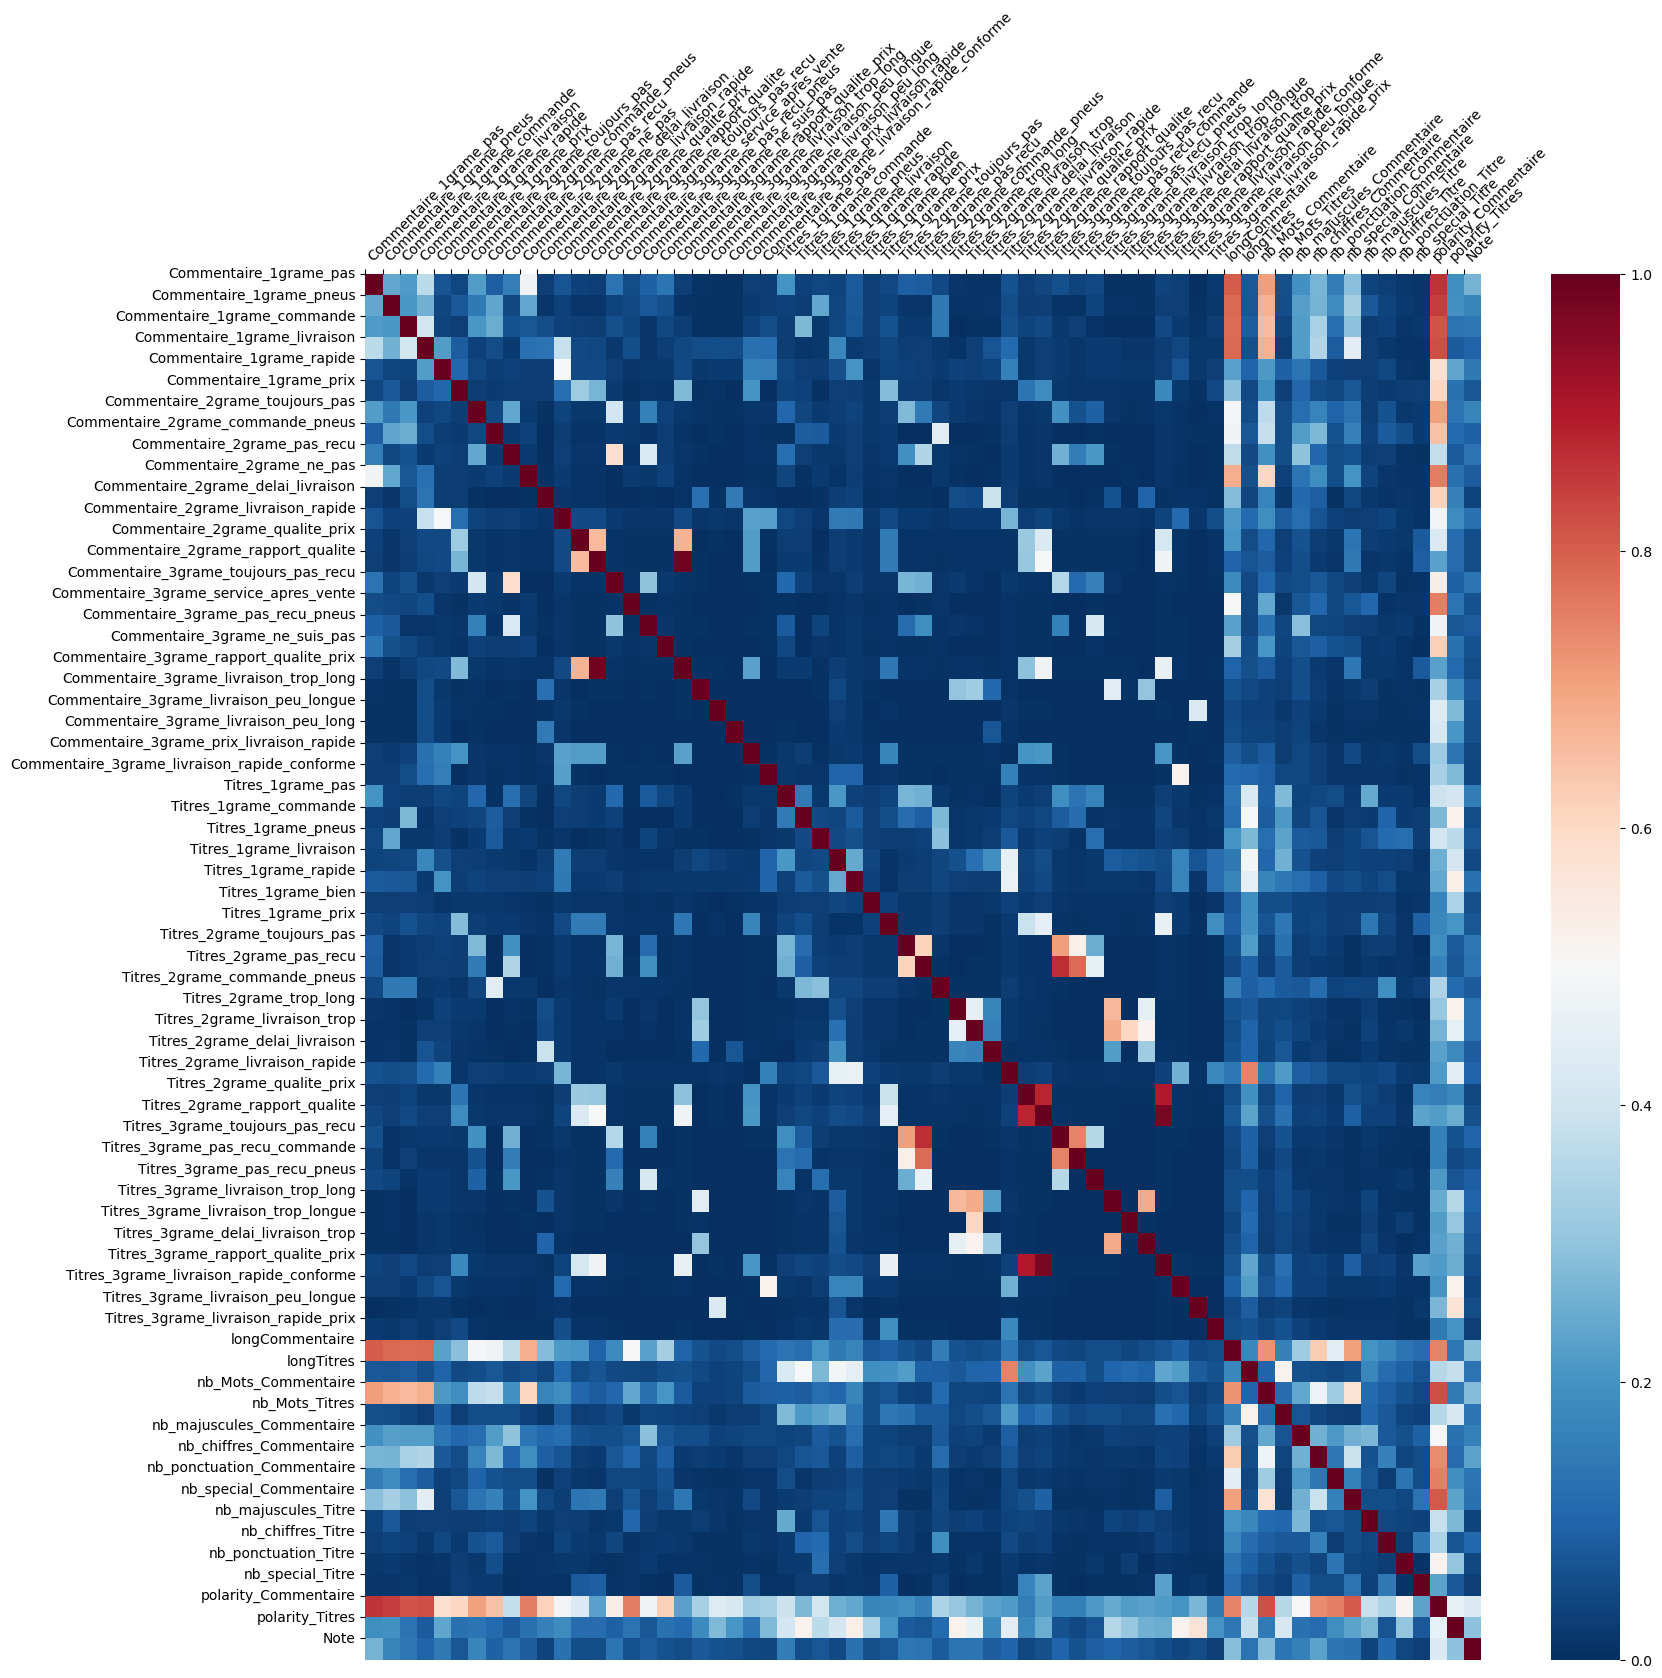

In [27]:
print(len(corr[0]))
print(len(catVar))
plt.figure(figsize=(18,18))
figcorr = sns.heatmap(np.array(corr),annot=False,cmap='RdBu_r')

figcorr.set_xticks(range(len(catVar)))
figcorr.set_yticks(range(len(catVar)))

figcorr.set_xticklabels(catVar)
figcorr.set_yticklabels(catVar)
figcorr.xaxis.tick_top()
plt.xticks(rotation=45)
plt.xticks(ha='left')
plt.yticks(rotation=0)